In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

In [2]:
path = r'Outputs'                     # use your path
all_files = glob.glob(os.path.join(path, "India*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df = pd.concat((pd.read_csv(f) for f in all_files))

In [3]:
df = df.sort_values(by = 'Unnamed: 0')

In [4]:
df = df.dropna()

In [5]:
df.index = df['Unnamed: 0']

In [6]:
df = df.drop(columns = ['Unnamed: 0'])

In [7]:
df *=1e12

In [8]:
CGP_df = pd.read_excel('BU_data/CGP-Database_2020-1-2.xlsx')

In [9]:
CGP_df.columns = CGP_df.columns.str.replace(' ', '_')

In [10]:
CGP_df = CGP_df.loc[CGP_df['Technology'] == 'Coal']

In [11]:
#CGEF_df['Country'] = CGEF_df['Country'].str.lower()
CGP_df['Country'] = CGP_df['Country'].str.lower()

In [12]:
CGP_df = CGP_df.loc[CGP_df['Region'] == 'Southeast Asia']

In [13]:
CGP_df['CO2_weighted_capacity_1000tonsperMW'] = CGP_df['Estimated_Annual_CO2_Emission_from_Power_Generation_(1000_ton)']/CGP_df['Capacity_(MW)']

In [14]:
CGP_op = CGP_df.loc[CGP_df['Project_Status'] == 'In Operation']

In [15]:
#######in progress retiring by year after co2#########
def early_retirement_by_CO2_year(year_early, df, CO2_val, time_array, shutdown_years):
    ''' df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day'''
    min_comission_yr = df['Year_of_Commission'].min()
    E = np.zeros(len(time_array))
        #print(year_comis)
    #print(CGP_op.loc[CGP_op.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
    test_array = np.where(time_array <= year_early, True, False)
    #plt.plot(test_array)
    E += test_array* df.loc[df.CO2_weighted_capacity_1000tonsperMW >= CO2_val]['Estimated_Annual_CO2_Emission_from_Power_Generation_(1000_ton)'].sum()
        #fig, ax = plt.subplots()
        #plt.plot(E[year])
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        #print(year_comis)
        #print(CGP_op.loc[CGP_op.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
        test_array = np.where((time_array <= (year_comis-min_comission_yr) + shutdown_years), True, False)
        #fig, ax = plt.subplots()
        #plt.plot(test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['BC_(g/day)'].sum())
        E += test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['Estimated_Annual_CO2_Emission_from_Power_Generation_(1000_ton)'].sum()
        #E[year] += (time_array>=0) * df.loc[df.CO2_weighted_capacity_1000tonsperMW < CO2_val]['BC_(g/day)'].sum()
        #plt.plot(E)

    
    return(E)



In [16]:
years = 50
coal_year_range = np.arange(0,41)

## Add time dimension
length_simulation = years
time_array = np.arange(0, length_simulation)

In [17]:
E_CO2_range_max_allyr = {}
for year in coal_year_range:
    E_CO2_range_max_allyr[year] = {}
    for r in np.arange(1,101):
        E_CO2_range_max_allyr[year][r] = early_retirement_by_CO2_year(year, CGP_op, np.percentile(CGP_op['CO2_weighted_capacity_1000tonsperMW'],r), time_array, 40)
        E_CO2_range_max_allyr[year][r] = E_CO2_range_max_allyr[year][r].sum()

In [18]:
CO2_df = pd.DataFrame(E_CO2_range_max_allyr).T

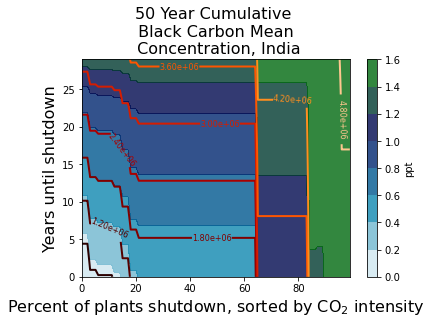

In [19]:
contours = plt.contour(CO2_df[:30], cmap = 'gist_heat', linewidths = 2)
plt.clabel(contours, fmt = '%1.2e', fontsize=8, inline = True)
plt.contourf(df, cmap = 'ocean_r', alpha = .8);
plt.colorbar(label = 'ppt')
plt.title('50 Year Cumulative \n Black Carbon Mean \n Concentration, India', fontsize = 16)
plt.xlabel(r'Percent of plants shutdown, sorted by CO$_2$ intensity', fontsize = 16)
plt.ylabel('Years until shutdown', fontsize = 16)
plt.ylim(0,29)
plt.savefig('figures/BC_mean_conc_India_conv.png', bbox_inches = 'tight', dpi = 200)

<a list of 7 text.Text objects>

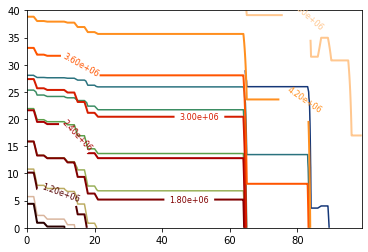

In [47]:
plt.contour(df, cmap = 'gist_earth_r');
contours = plt.contour(CO2_df, cmap = 'gist_heat', linewidths = 2)
plt.clabel(contours, fmt = '%1.2e', fontsize=8, inline = True)